In [3]:
import pickle
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Just to be explicit, though in newer Matplotlib versions not always needed
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

In [6]:

sims_path = 'spatial_sims/sim_data/'
sims_results_files = os.listdir(sims_path)
sims_data_dic = {}
for i, sim_file in enumerate(sims_results_files):
    with open(os.path.join(sims_path, sim_file),'rb') as f:
        sims_data = pickle.load(f)
        sims_data_dic[i] = sims_data


Text(0.5, 1.0, 'speed modulation profile')

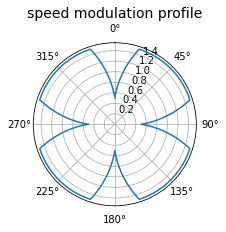

In [8]:
n_bins_total = 360
speed_factors = np.zeros(n_bins_total)
angles = np.linspace(0, 2 * np.pi, num=n_bins_total, endpoint=False)
for segment_start in [0, 90, 180, 270]:
        segment_end = segment_start + 90
        for i in range(segment_start, segment_end):
            frac = (i - segment_start) / 90.0
            # We'll do a simple "accelerate-decelerate" pattern:
            if frac < 0.2:
                # accelerate from 0.5 to 1.5
                speed = 0.5 + (1.0 * (frac / 0.2))
            elif frac > 0.8:
                # decelerate from 1.5 to 0.5
                speed = 1.5 - (1.0 * ((frac - 0.8) / 0.2))
            else:
                # cruise at 1.5
                speed = 1.5
            speed_factors[i] = speed


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, 
                            figsize=(12, 3), sharex=False)

ax.plot(angles, speed_factors)

# Optional styling for polar plots
ax.set_theta_zero_location('N')  # 0 degrees at the top
ax.set_theta_direction(-1)       # Clockwise increasing angle               # Max radius (adjust to taste)
ax.set_title(f"speed modulation profile", fontsize=14)

In [9]:
positions = sims_data_dic[0]['sessions'][0]['trials_data'][0]['positions_timebins']
filtered_positions = [positions[i] for i in range(len(positions)) if i == 0 or positions[i] != positions[i - 1]]
;
print(filtered_positions)

[7, 4, 1, 2, 3, 2, 5, 6, 5, 4, 7]


In [11]:
def compute_mean_firing(sim_data):
    n_sessions = sim_data["n_sessions"]
    n_trials = sim_data["n_trials"]
    n_neurons = sim_data["n_neurons"]

    mean_rates_list = []
    T = None

    for s_idx in range(n_sessions):
        session_dict = sim_data["sessions"][s_idx]
        trials_data = session_dict["trials_data"]
        
        if T is None:
            T = trials_data[0]["spikes"].shape[1]  # e.g. 360

        all_spikes = np.zeros((n_trials, n_neurons, T), dtype=float)
        for t_idx in range(n_trials):
            all_spikes[t_idx, :, :] = trials_data[t_idx]["spikes"]

        # Mean across trials -> shape (n_neurons, T)
        session_mean = all_spikes.mean(axis=0)
        mean_rates_list.append(session_mean)

    # shape: (n_sessions, n_neurons, T)
    mean_rates = np.stack(mean_rates_list, axis=0)
    return mean_rates

###################
# 3) CIRCULAR SMOOTHING
###################
def circular_smooth_1d(data_1d, window_size=5):
    T = len(data_1d)
    triple = np.concatenate([data_1d, data_1d, data_1d])
    kernel = np.ones(window_size) / window_size
    convolved = np.convolve(triple, kernel, mode='same')
    start = T
    end = 2*T
    smoothed = convolved[start:end]
    return smoothed

def smooth_mean_firing(mean_rates, window_size=5):
    n_sessions, n_neurons, T = mean_rates.shape
    smoothed_rates = np.zeros_like(mean_rates)

    for s_idx in range(n_sessions):
        for n_idx in range(n_neurons):
            fr_1d = mean_rates[s_idx, n_idx, :]
            fr_1d_smooth = circular_smooth_1d(fr_1d, window_size=window_size)
            smoothed_rates[s_idx, n_idx, :] = fr_1d_smooth

    return smoothed_rates

window_size = 5  # or pick another size
mean_rates_dic = {}
smoothed_rates_dic = {}
for i in sims_data_dic:
    mean_rates = compute_mean_firing(sims_data_dic[i])
    smoothed_rates = smooth_mean_firing(mean_rates, window_size)
    mean_rates_dic[i] = mean_rates
    smoothed_rates_dic[i] = smoothed_rates

###################
# 4) OPTIONAL: SAVE
###################

UMAP embedding shape: (360, 3)


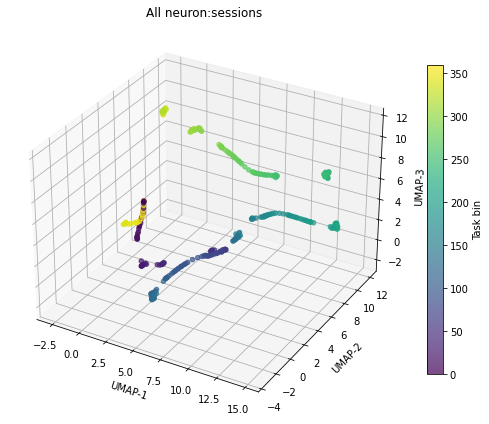

In [12]:
# -------------------------
# Preprocessing (Optional)
# -------------------------
# Standard scaling the data so that each feature (neuron) has zero mean and unit variance.



all_neurons_concat = []
for day in smoothed_rates_dic:
    smoothed_rates = smoothed_rates_dic[day]
    for session in smoothed_rates:
        all_neurons_concat.append(session)
all_neurons_concat = np.vstack((all_neurons_concat))


labels = list(range(360))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(all_neurons_concat.T)

# -------------------------
# UMAP Dimensionality Reduction
# -------------------------
# We set n_components=3 to get a 3D embedding.

#MY PARAMS
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
X_embedding = reducer.fit_transform(X_scaled)


# YOUR PARAMS (plus random state for reproducability)
# reducer = umap.UMAP(n_components = 3, metric = 'cosine', n_neighbors = 50, min_dist = 0.6, random_state=42)
# X_embedding = reducer.fit_transform(X_scaled)




# X_embedding will now be of shape (n_samples, 3)
print("UMAP embedding shape:", X_embedding.shape)

# -------------------------
# Visualization
# -------------------------
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot: we color points by their condition/label
scatter = ax.scatter(X_embedding[:,0], X_embedding[:,1], X_embedding[:,2], 
                     c=labels, cmap='viridis', alpha=0.7)

ax.set_title('All neuron:sessions')
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')

# Optionally add a legend or colorbar
cbar = plt.colorbar(scatter, ax=ax, fraction=0.03)
cbar.set_label('Task bin')

plt.tight_layout()
plt.show()

UMAP embedding shape: (360, 3)


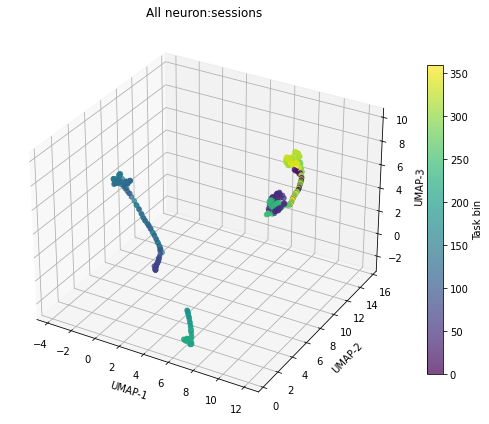

In [20]:
# -------------------------
# Preprocessing (Optional)
# -------------------------
# Standard scaling the data so that each feature (neuron) has zero mean and unit variance.



all_neurons_concat = []
for day in smoothed_rates_dic:
    smoothed_rates = smoothed_rates_dic[day]
    for session in smoothed_rates:
        all_neurons_concat.append(session)
all_neurons_concat = smoothed_rates_dic[1][1]


labels = list(range(360))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(all_neurons_concat.T)

# -------------------------
# UMAP Dimensionality Reduction
# -------------------------
# We set n_components=3 to get a 3D embedding.

#MY PARAMS
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
X_embedding = reducer.fit_transform(X_scaled)


# YOUR PARAMS (plus random state for reproducability)
# reducer = umap.UMAP(n_components = 3, metric = 'cosine', n_neighbors = 50, min_dist = 0.6, random_state=42)
# X_embedding = reducer.fit_transform(X_scaled)




# X_embedding will now be of shape (n_samples, 3)
print("UMAP embedding shape:", X_embedding.shape)

# -------------------------
# Visualization
# -------------------------
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot: we color points by their condition/label
scatter = ax.scatter(X_embedding[:,0], X_embedding[:,1], X_embedding[:,2], 
                     c=labels, cmap='viridis', alpha=0.7)

ax.set_title('All neuron:sessions')
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_zlabel('UMAP-3')

# Optionally add a legend or colorbar
cbar = plt.colorbar(scatter, ax=ax, fraction=0.03)
cbar.set_label('Task bin')

plt.tight_layout()
plt.show()

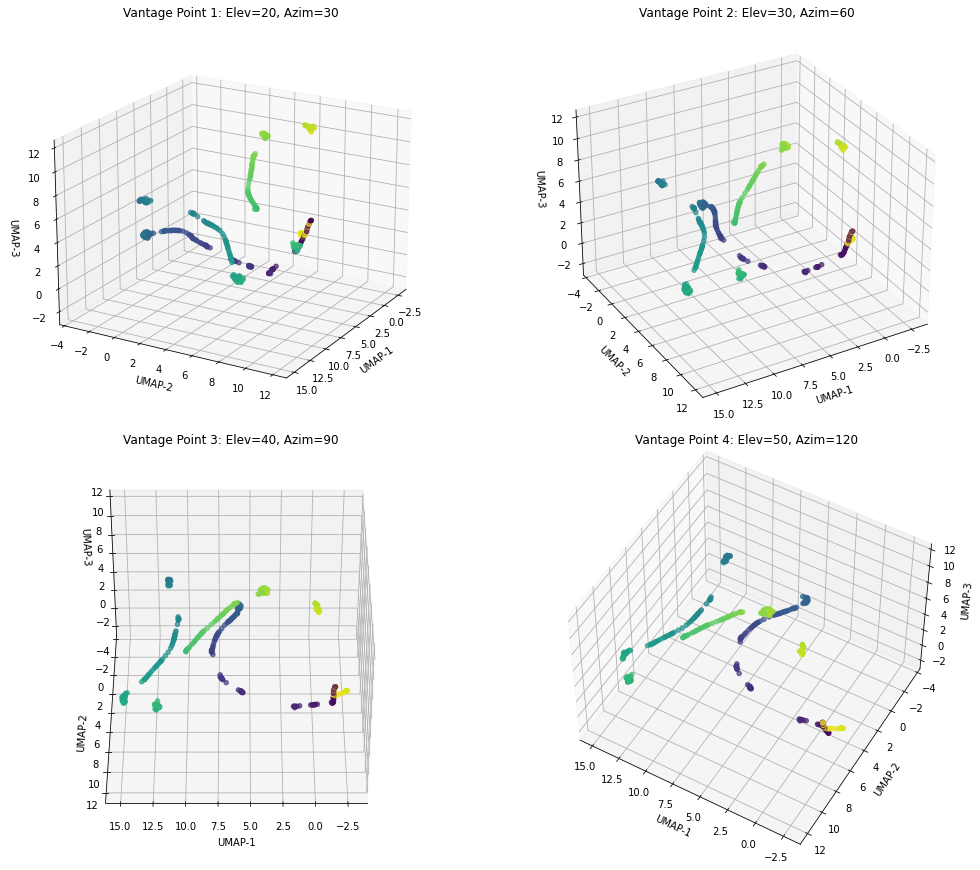

In [14]:
fig = plt.figure(figsize=(16, 12))

# Define different vantage points
vantage_points = [(20, 30), (30, 60), (40, 90), (50, 120)]

for i, (elev, azim) in enumerate(vantage_points):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d')
    
    # Scatter plot: we color points by their condition/label
    scatter = ax.scatter(X_embedding[:,0], X_embedding[:,1], X_embedding[:,2], 
                         c=labels, cmap='viridis', alpha=0.7)
    
    ax.set_title(f'Vantage Point {i+1}: Elev={elev}, Azim={azim}')
    ax.set_xlabel('UMAP-1')
    ax.set_ylabel('UMAP-2')
    ax.set_zlabel('UMAP-3')
    
    # Set the view angle
    ax.view_init(elev=elev, azim=azim)

# Optionally add a legend or colorbar
# cbar = fig.colorbar(scatter, ax=fig.get_axes(), fraction=0.03, pad=0.04)
# cbar.set_label('Task bin')

plt.tight_layout()
plt.show()

In [17]:
for i in sims_data_dic:
    print(f"sims recday {i}")
    for session in sims_data_dic[i]['sessions']:
        print(session['tower_sequence'])

sims recday 0
[7, 3, 5, 6]
[5, 6, 8, 9]
[9, 7, 8, 1]
[2, 7, 3, 4]
[3, 4, 5, 7]
sims recday 1
[4, 2, 9, 6]
[3, 9, 8, 6]
[7, 4, 3, 1]
[2, 6, 9, 8]
[6, 8, 9, 7]
sims recday 2
[2, 5, 9, 7]
[9, 1, 3, 6]
[1, 4, 3, 6]
[4, 1, 9, 3]
[3, 6, 9, 8]
